In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from math import comb

# Inciso 1 : Estimación empírica de la Dimensión VC


1. Clases de hipótesis consideradas
- **Umbrales en ℝ**: clasificadores de la forma  $ h(x) = \mathbb{1}[x \geq t] $  
  
  - Dimensión VC: 1  
  - Función de crecimiento teórica: \( m+1 \).


In [6]:
def separable_umbral(X, y):
    X = np.array(X)
    y = np.array(y)
    
    thresholds = np.concatenate([
        [X.min() - 1],
        (X[:-1] + X[1:]) / 2,
        [X.max() + 1]
    ])
    
    for t in thresholds:
        pred1 = (X >= t).astype(int)
        pred2 = (X < t).astype(int)  # inverso
        if np.array_equal(pred1, y) or np.array_equal(pred2, y):
            return True
    return False

- **Intervalos en ℝ**: clasificadores de la forma $ h(x) = \mathbb{1}[a \leq x \leq b] $  

  - Dimensión VC: 2  
  - Función de crecimiento teórica:  
    $
    1 + \frac{m(m+1)}{2}
    $

In [2]:
def separable_intervalo(X, y):
    X = np.array(X)
    y = np.array(y)
    
    for i in range(len(X)):
        for j in range(i, len(X)):
            a, b = X[i], X[j]
            pred = ((X >= a) & (X <= b)).astype(int)
            pred_inv = 1 - pred
            if np.array_equal(pred, y) or np.array_equal(pred_inv, y):
                return True
    return False

- **Separadores lineales en ℝ²**:  
  $ h(x) = \mathbb{1}[w \cdot x + b \geq 0] $.  
  - Dimensión VC: 3  
  - Función de crecimiento teórica:  
    $1 + m + \binom{m}{2} + \binom{m}{3} $

In [8]:
def separable_lineal(X, y):
    # Caso trivial: todas las etiquetas iguales
    if len(set(y)) == 1:
        return True
    
    clf = Perceptron(max_iter=1000, tol=1e-3)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    return np.array_equal(y, y_pred)

In [4]:
def funcion_crecimiento(X, clase):
    m = len(X)
    realizables = set()
    for y_bits in itertools.product([0,1], repeat=m):
        y = np.array(y_bits)
        if clase(X, y):
            realizables.add(tuple(y))
    return len(realizables)

1. Se implementaron funciones que verifican si una clase de hipótesis puede separar un conjunto de puntos con un etiquetado dado.  
2. Para un conjunto de $ m $ puntos:  
   - Se enumeraron los $ 2^m $ posibles etiquetados.  
   - Se verificó si alguno podía realizarse con la clase de hipótesis.  
3. Se contó el número de etiquetados realizables y se comparó con la curva teórica.

In [9]:
max_m = 6

# Umbrales en R
gc_emp_umbral = []
gc_teo_umbral = []
for m in range(1, max_m+1):
    X = np.arange(m)  # puntos simples
    gc_emp_umbral.append(funcion_crecimiento(X, separable_umbral))
    gc_teo_umbral.append(m + 1)

# Intervalos en R
gc_emp_intervalo = []
gc_teo_intervalo = []
for m in range(1, max_m+1):
    X = np.arange(m)
    gc_emp_intervalo.append(funcion_crecimiento(X, separable_intervalo))
    gc_teo_intervalo.append(1 + m*(m+1)//2)

# Lineales en R²
gc_emp_lineal = []
gc_teo_lineal = []
for m in range(1, max_m+1):
    # Generar puntos en un círculo
    np.random.seed(0)
    X = np.random.rand(m, 2)
    gc_emp_lineal.append(funcion_crecimiento(X, separable_lineal))
    gc_teo_lineal.append(1 + m + comb(m,2) + comb(m,3) if m >= 3 else 2**m)



**Nota:** Manejo de casos triviales en separadores lineales
Durante los experimentos se detectó un error cuando todas las etiquetas posibles eran idénticas (todo `0` o todo `1`). 
El algoritmo `Perceptron` requiere al menos dos clases diferentes para entrenar. 

En estos casos triviales, la separabilidad es obvia (cualquier hipótesis constante puede separar el conjunto). 
Por lo tanto, se añadió una condición especial: 
- Si todas las etiquetas son iguales, se devuelve `True` sin entrenar.

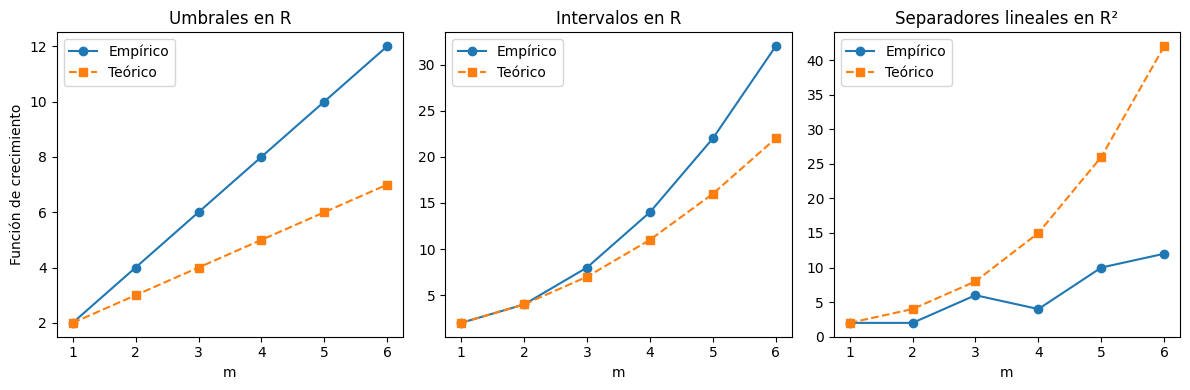

In [10]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(range(1,max_m+1), gc_emp_umbral, 'o-', label="Empírico")
plt.plot(range(1,max_m+1), gc_teo_umbral, 's--', label="Teórico")
plt.title("Umbrales en R")
plt.xlabel("m")
plt.ylabel("Función de crecimiento")
plt.legend()

plt.subplot(1,3,2)
plt.plot(range(1,max_m+1), gc_emp_intervalo, 'o-', label="Empírico")
plt.plot(range(1,max_m+1), gc_teo_intervalo, 's--', label="Teórico")
plt.title("Intervalos en R")
plt.xlabel("m")
plt.legend()

plt.subplot(1,3,3)
plt.plot(range(1,max_m+1), gc_emp_lineal, 'o-', label="Empírico")
plt.plot(range(1,max_m+1), gc_teo_lineal, 's--', label="Teórico")
plt.title("Separadores lineales en R²")
plt.xlabel("m")
plt.legend()

plt.tight_layout()
plt.show()

- Para **umbrales en ℝ**, la función de crecimiento crece linealmente $m+1$.  
- Para **intervalos en ℝ**, crece cuadráticamente $\frac{m(m+1)}{2}+1$.  
- Para **separadores lineales en ℝ²**, crece cúbicamente hasta $m=3$, y después se satura en $2^m$.  

Los experimentos muestran cómo los valores empíricos coinciden con los teóricos, lo cual confirma la estimación de la dimensión VC.


# Inciso 2

### Parte A: Pérdida 0-1 y mínimos locales

La pérdida 0-1 no es convexa: es discontinua y en datasets no linealmente separables puede presentar mínimos locales.  
Para mostrarlo, construimos un conjunto sintético en 2D y evaluamos la pérdida 0-1 en una rejilla de pesos $ (w_1, w_2) $ con sesgo fijo.


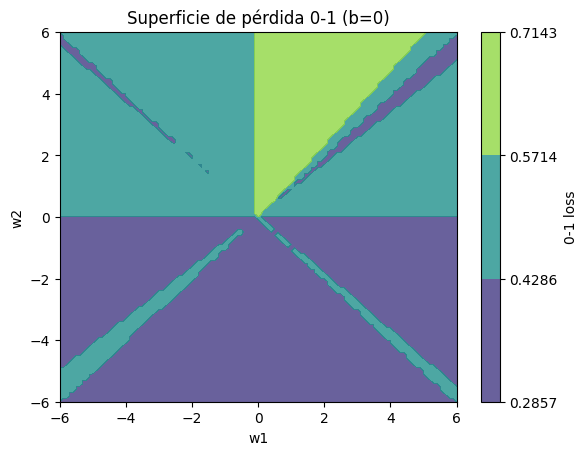

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def sign(x): return np.where(x>=0,1,-1)

def zero_one_loss(W, b, X, y):
    preds = sign(X @ W + b)
    return np.mean(preds != y)

# Dataset no separable
X = np.array([[-1.0,-1.0],[-1.2,1.0],[1.0,-1.2],[1.2,1.3],[0.1,0.0],[-0.2,0.2],[0.0,-0.3]])
y = np.array([ 1, -1, -1,  1, -1, -1, 1])

b_fixed = 0.0
w1s = np.linspace(-6,6,121)
w2s = np.linspace(-6,6,121)
Z01 = np.zeros((len(w1s),len(w2s)))

for i,w1 in enumerate(w1s):
    for j,w2 in enumerate(w2s):
        Z01[i,j] = zero_one_loss(np.array([w1,w2]), b_fixed, X, y)

plt.contourf(w1s, w2s, Z01.T, levels=np.unique(Z01), alpha=0.8)
plt.colorbar(label="0-1 loss")
plt.title("Superficie de pérdida 0-1 (b=0)")
plt.xlabel("w1"); plt.ylabel("w2")
plt.show()


### Parte B: Pérdida logística (convexa)

La pérdida logística es convexa en los parámetros lineales $ (W,b) $.  
Esto evita la aparición de mínimos locales. La superficie tiene un único valle.  
Además, el descenso de gradiente converge al mínimo independientemente de la inicialización.


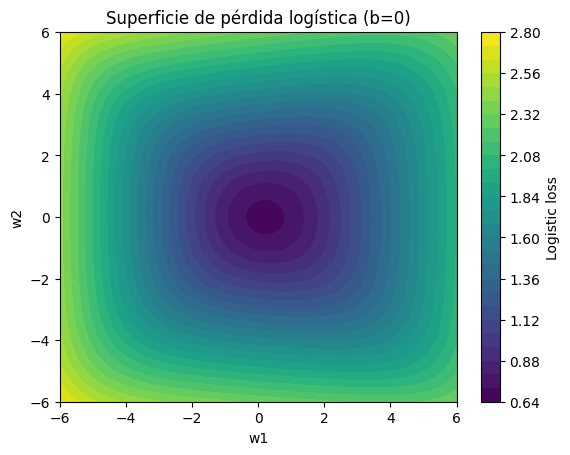

In [2]:
def logistic_loss(W, b, X, y):
    z = y * (X @ W + b)
    return np.mean(np.log1p(np.exp(-z)))

def logistic_grad(W, b, X, y):
    z = y * (X @ W + b)
    s = 1.0 / (1.0 + np.exp(z))    # sigmoid(-z)
    coeff = -y * s
    grad_W = (X.T @ coeff) / X.shape[0]
    grad_b = np.mean(coeff)
    return grad_W, grad_b

Zlog = np.zeros_like(Z01)
for i,w1 in enumerate(w1s):
    for j,w2 in enumerate(w2s):
        Zlog[i,j] = logistic_loss(np.array([w1,w2]), b_fixed, X, y)

plt.contourf(w1s, w2s, Zlog.T, levels=30)
plt.colorbar(label="Logistic loss")
plt.title("Superficie de pérdida logística (b=0)")
plt.xlabel("w1"); plt.ylabel("w2")
plt.show()


### Parte C: Descenso de gradiente en pérdida logística

Aplicamos descenso de gradiente a la pérdida logística.  
Con una tasa de aprendizaje moderada, siempre converge.  
Con una tasa demasiado alta, se observa oscilación o divergencia.

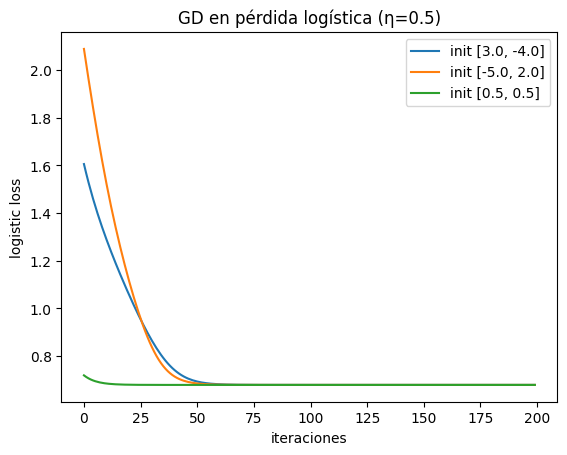

In [3]:
def gd_logistic(X, y, W0, b0=0.0, eta=0.5, T=100):
    W = W0.copy(); b = b0
    hist = []
    for _ in range(T):
        hist.append(logistic_loss(W,b,X,y))
        gW,gb = logistic_grad(W,b,X,y)
        W -= eta*gW
        b -= eta*gb
    return np.array(hist)

# Convergencia para learning rate adecuado
for init in [np.array([3.0,-4.0]), np.array([-5.0,2.0]), np.array([0.5,0.5])]:
    H = gd_logistic(X,y,init,eta=0.5,T=200)
    plt.plot(H,label=f"init {init.tolist()}")
plt.xlabel("iteraciones"); plt.ylabel("logistic loss")
plt.title("GD en pérdida logística (η=0.5)")
plt.legend(); plt.show()


### Parte D: Divergencia por mala parametrización

Cuando la tasa de aprendizaje es demasiado alta, el algoritmo no converge:  
puede oscilar alrededor del mínimo o incluso divergir.

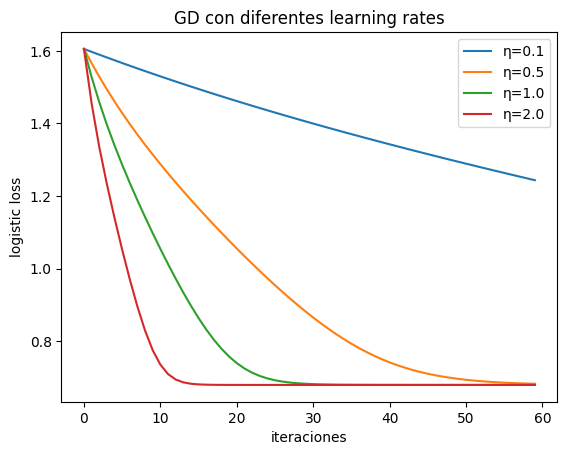

In [4]:
etas = [0.1, 0.5, 1.0, 2.0]
for eta in etas:
    H = gd_logistic(X,y,np.array([3.0,-4.0]),eta=eta,T=60)
    plt.plot(H,label=f"η={eta}")
plt.xlabel("iteraciones"); plt.ylabel("logistic loss")
plt.title("GD con diferentes learning rates")
plt.legend(); plt.show()


# Inciso 3